In [1]:
# prompt: connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !apt-get update
# !apt-get install tesseract-ocr
# !pip install pytesseract
# pip install opencv-python-headless matplotlib pytesseract joblib

In [7]:
import cv2
import pytesseract
from pytesseract import Output
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [9]:
# Read the image
image_path = '/content/drive/My Drive/SRI/Images/Text2.png'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to get a binary image
_, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


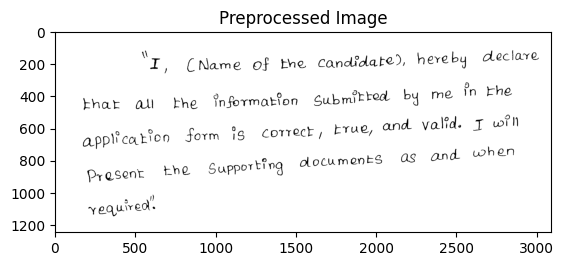

In [10]:
# Display the preprocessed image
plt.imshow(binary_image, cmap='gray')
plt.title('Preprocessed Image')
plt.show()

In [11]:
custom_config = r'--oem 3 --psm 6'
d = pytesseract.image_to_boxes(binary_image, config=custom_config, output_type=Output.DICT)


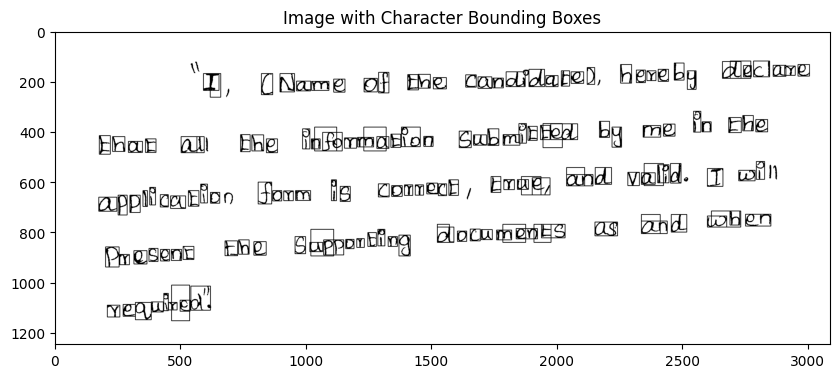

In [12]:
# Create a copy of the original image to draw bounding boxes
boxed_image = binary_image.copy()

# Draw bounding boxes around each detected character
for i in range(len(d['char'])):
    (x, y, w, h) = (d['left'][i], d['bottom'][i], d['right'][i], d['top'][i])
    area = (w - x) * (binary_image.shape[0] - y - (binary_image.shape[0] - h))
    if area >= 1000:
        cv2.rectangle(boxed_image, (x, binary_image.shape[0] - y), (w, binary_image.shape[0] - h), (0, 255, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Character Bounding Boxes')
plt.show()


In [13]:
# Extract character images and store them in an array
character_images = []
for i in range(len(d['char'])):
    (x, y, w, h) = (d['left'][i], d['bottom'][i], d['right'][i], d['top'][i])
    # Tesseract coordinates are relative to the bottom-left of the image
    # OpenCV coordinates are relative to the top-left of the image
    area = (w - x) * (binary_image.shape[0] - y - (binary_image.shape[0] - h))
    if area >= 1000:
        char_img = binary_image[binary_image.shape[0] - h:binary_image.shape[0] - y, x:w]
        character_images.append(char_img)



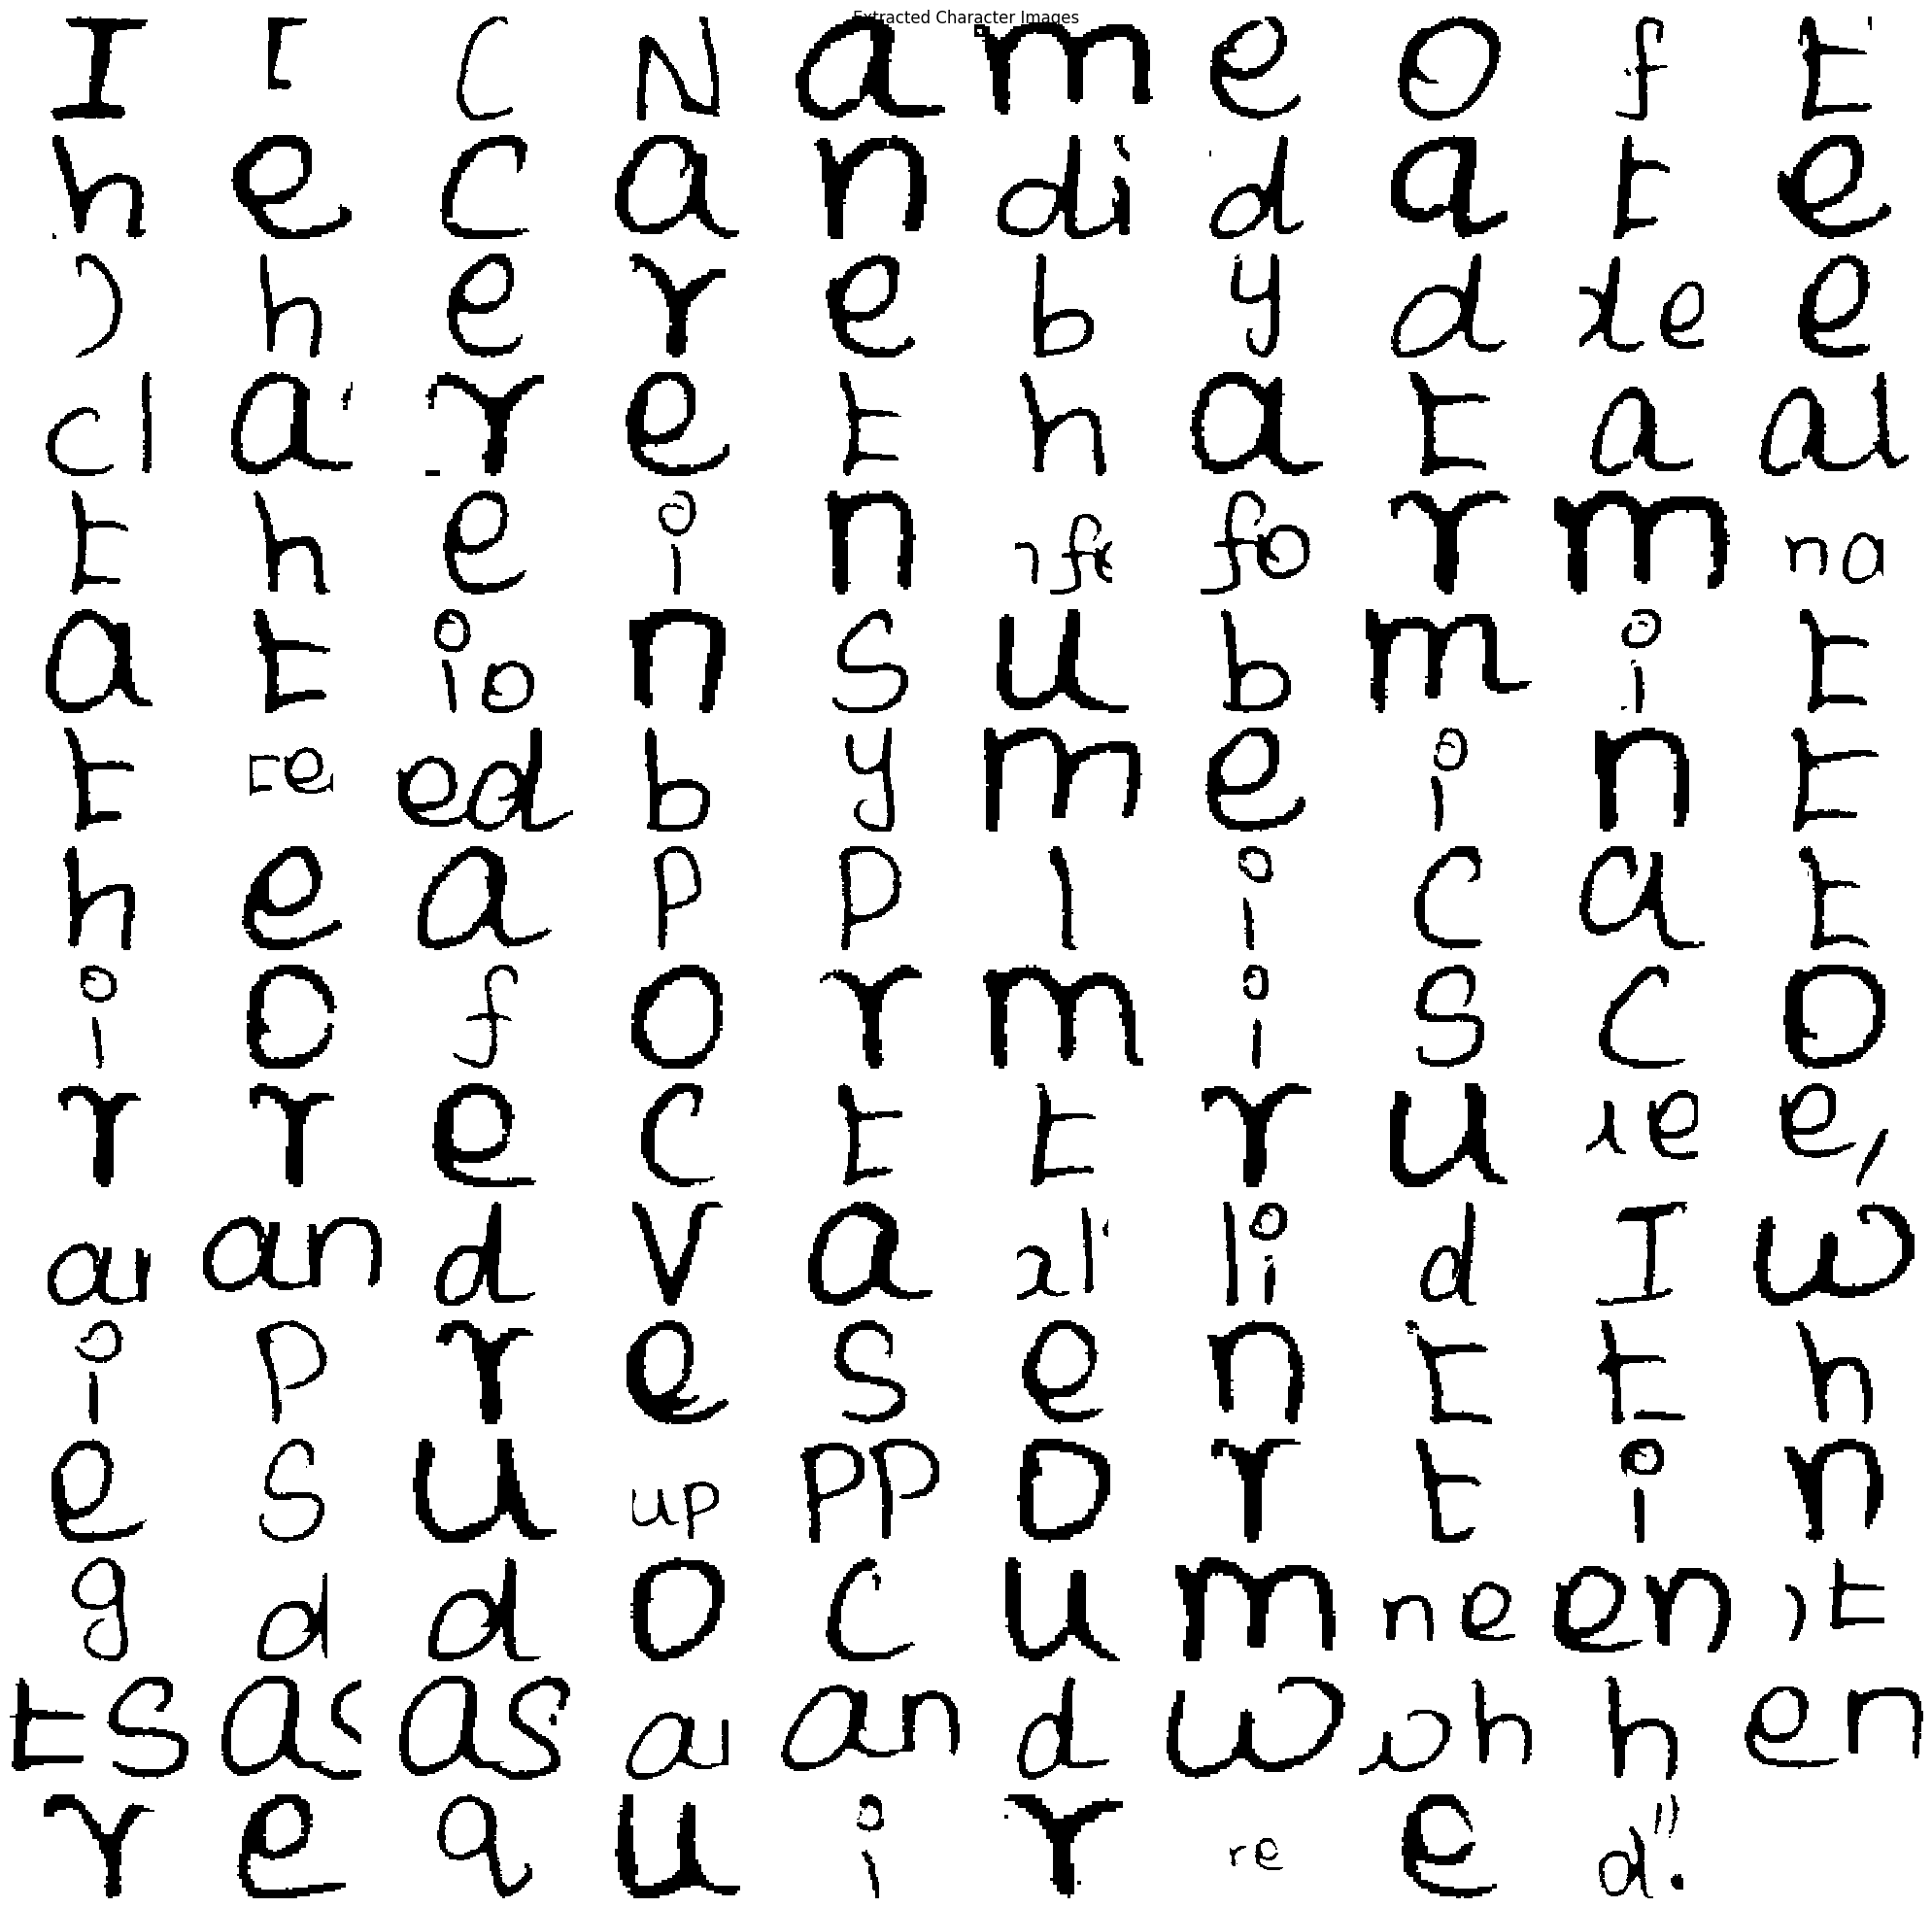

In [14]:
# Display all extracted character images
num_images = len(character_images)
rows = int(np.ceil(num_images / 10))  # Calculate number of rows needed
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(rows, 10, i+1)  # Adjust subplot grid size according to the number of characters

    # Ensure aspect ratio is maintained by setting interpolation to 'nearest'
    plt.imshow(character_images[i], cmap='gray', interpolation='nearest')

    plt.axis('off')
plt.suptitle('Extracted Character Images')
plt.tight_layout()  # Ensure tight layout
plt.show()

In [15]:
def process_image(image, target_size=(400, 300), extra_padding=(70, 70), background_color=(255, 255, 255)):
    # Convert the numpy array to a PIL image
    img = Image.fromarray(image)

    # Ensure the image has an alpha channel (RGBA mode)
    img = img.convert("RGBA")

    # Calculate the size of the new image including extra padding
    new_width = img.width + 2 * extra_padding[0]
    new_height = img.height + 2 * extra_padding[1]

    # Create a new image with white background and extra padding
    new_img = Image.new("RGBA", (new_width, new_height), background_color)

    # Calculate the position to paste the original image
    paste_x = extra_padding[0]
    paste_y = extra_padding[1]

    # Paste the original image onto the new image
    new_img.paste(img, (paste_x, paste_y), img)

    # Resize the image to the target size
    new_img = new_img.resize(target_size, Image.ANTIALIAS)

    # Convert back to RGB mode
    new_img = new_img.convert("RGB")

    # Convert the image back to a numpy array
    return np.array(new_img)

In [16]:
# List to store the processed images
processed_images = []

# Process each image and append to the processed_images array
for image in character_images:
    processed_image = process_image(image)
    processed_images.append(processed_image)

<ipython-input-15-4685666fc730>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = new_img.resize(target_size, Image.ANTIALIAS)


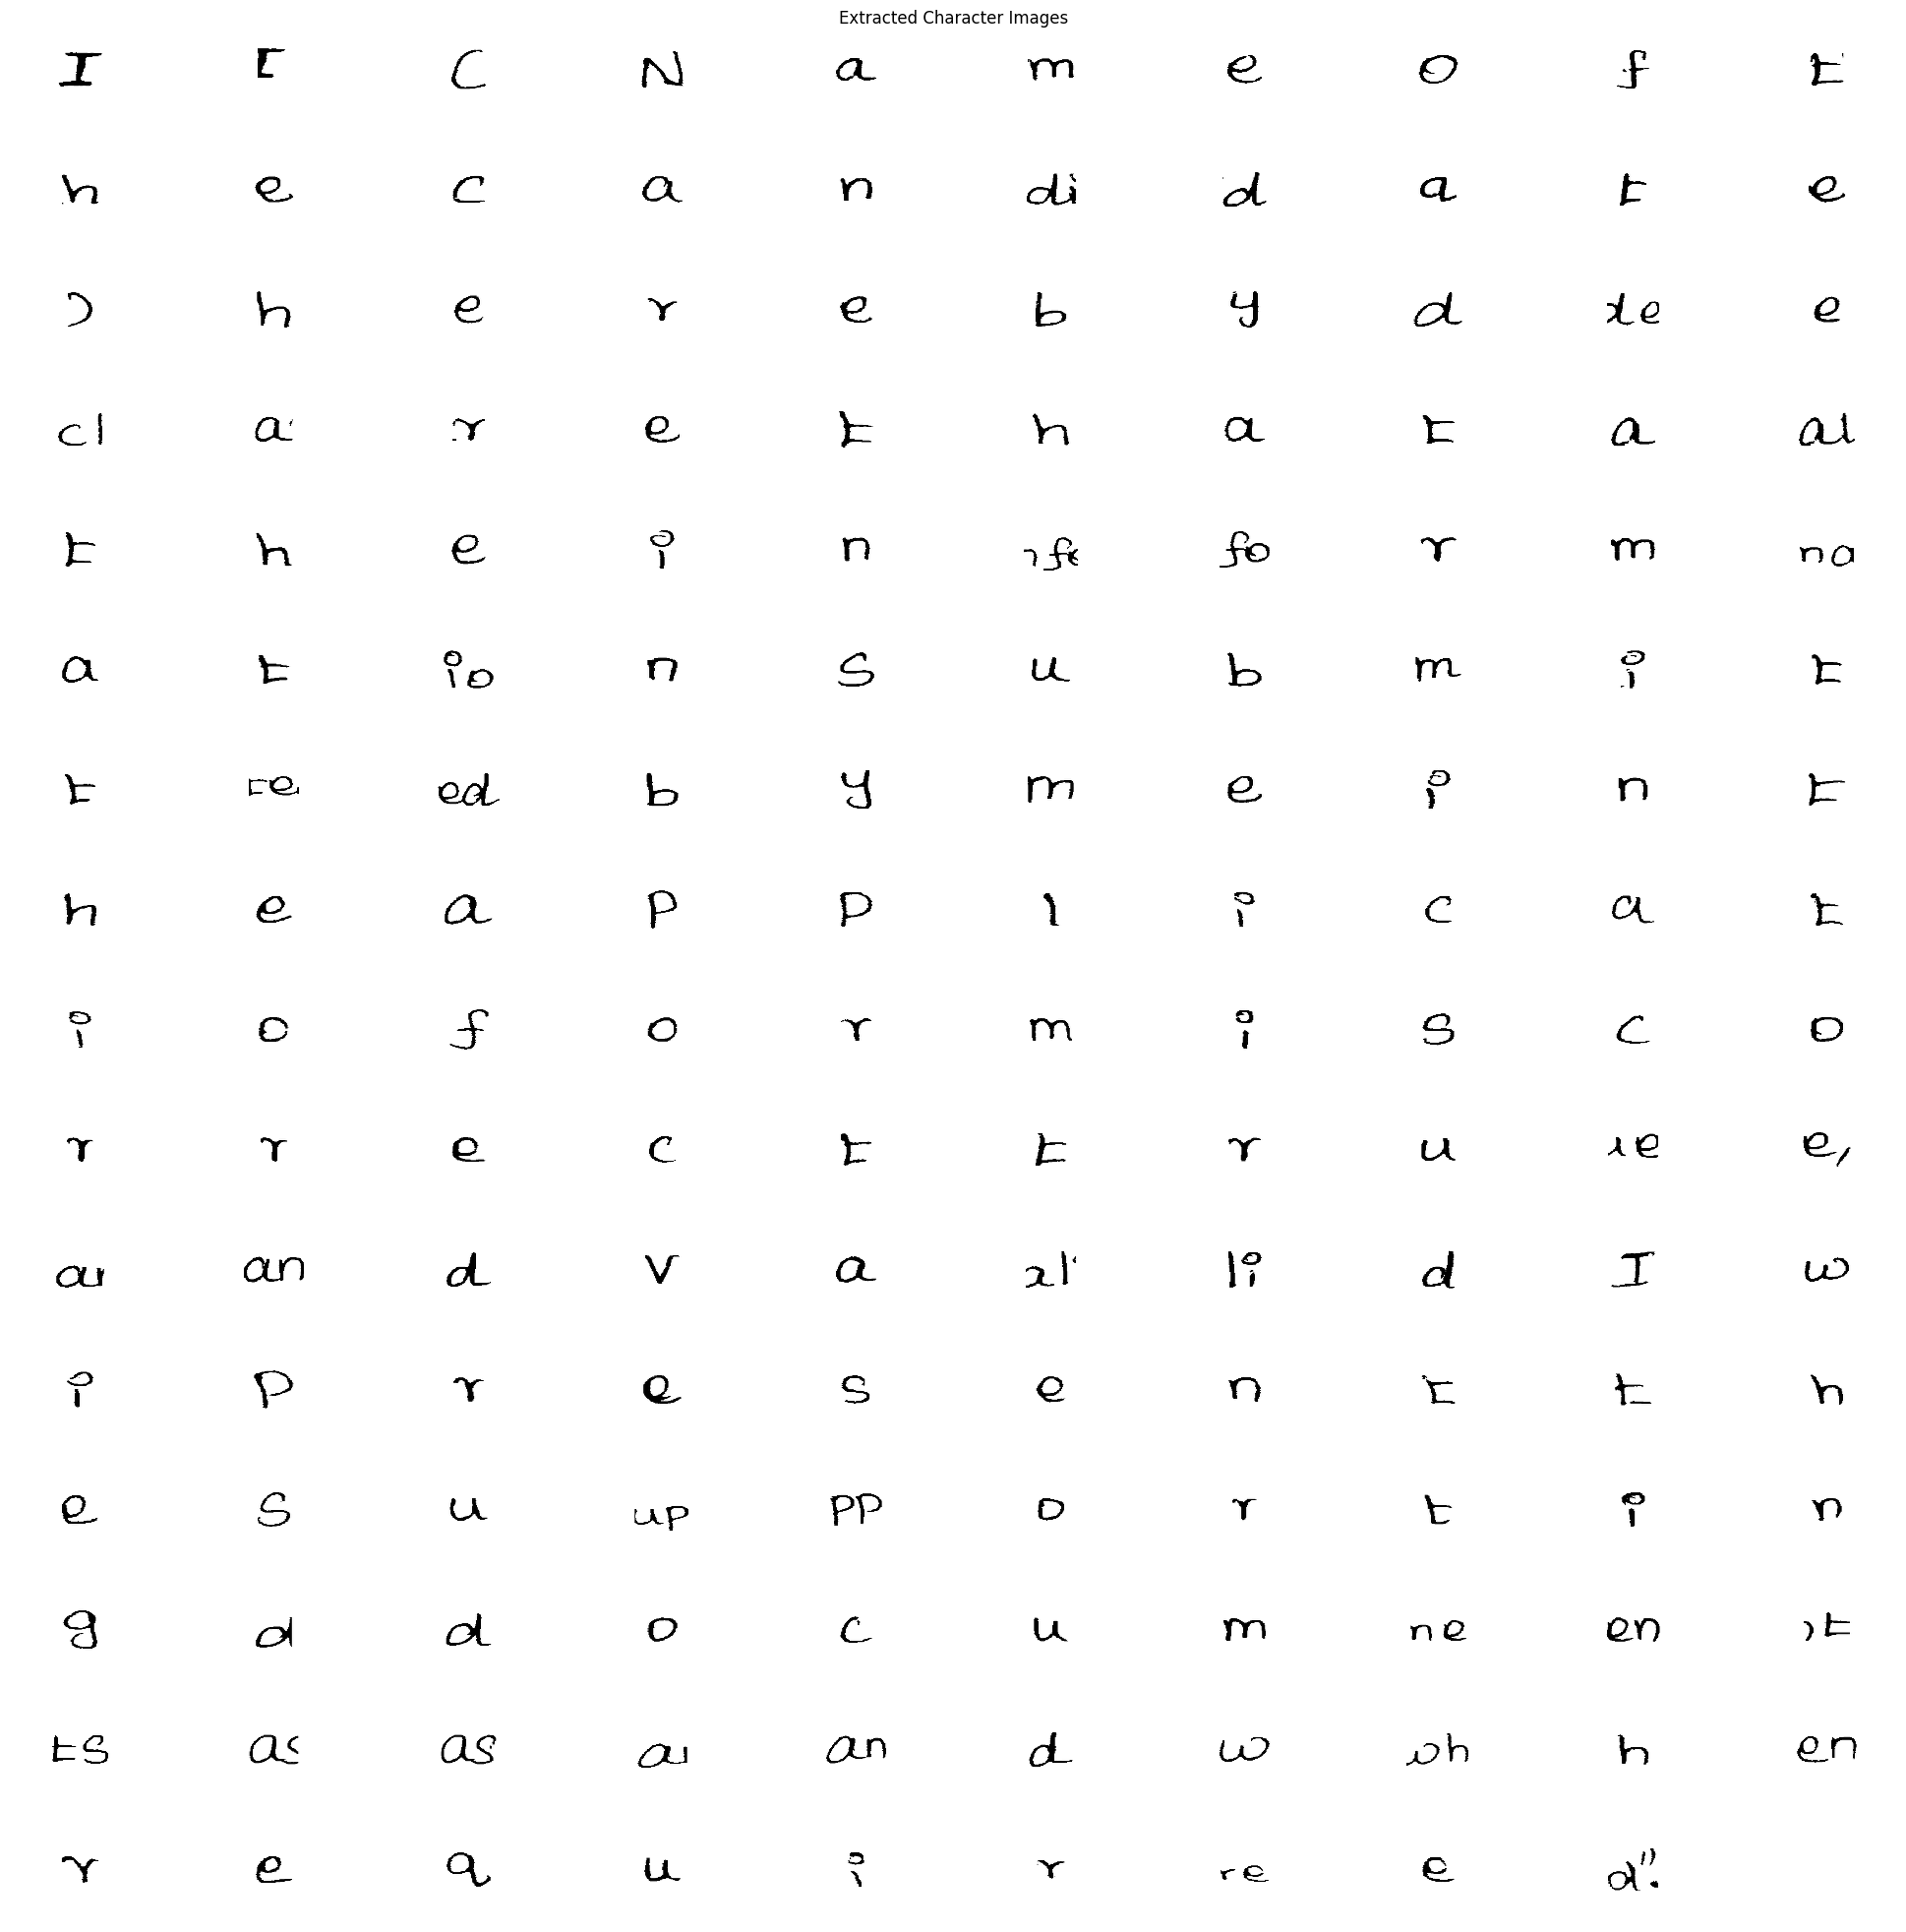

In [17]:
# Display all extracted character images
num_images = len(processed_images)
rows = int(np.ceil(num_images / 10))  # Calculate number of rows needed
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(rows, 10, i+1)  # Adjust subplot grid size according to the number of characters

    # Ensure aspect ratio is maintained by setting interpolation to 'nearest'
    plt.imshow(processed_images[i], cmap='gray', interpolation='nearest')

    plt.axis('off')
plt.suptitle('Extracted Character Images')
plt.tight_layout()  # Ensure tight layout
plt.show()

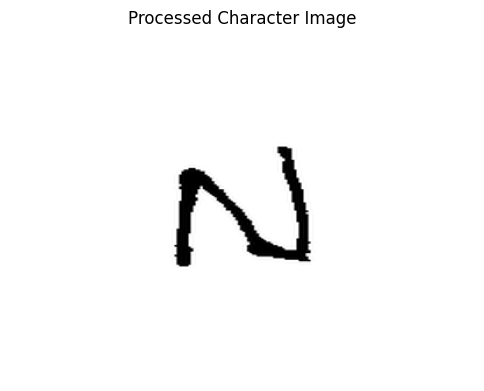

In [18]:
plt.figure(figsize=(6, 6))
plt.imshow(processed_images[3], cmap='gray')  # Display the first processed image
plt.axis('off')
plt.title('Processed Character Image')
plt.show()

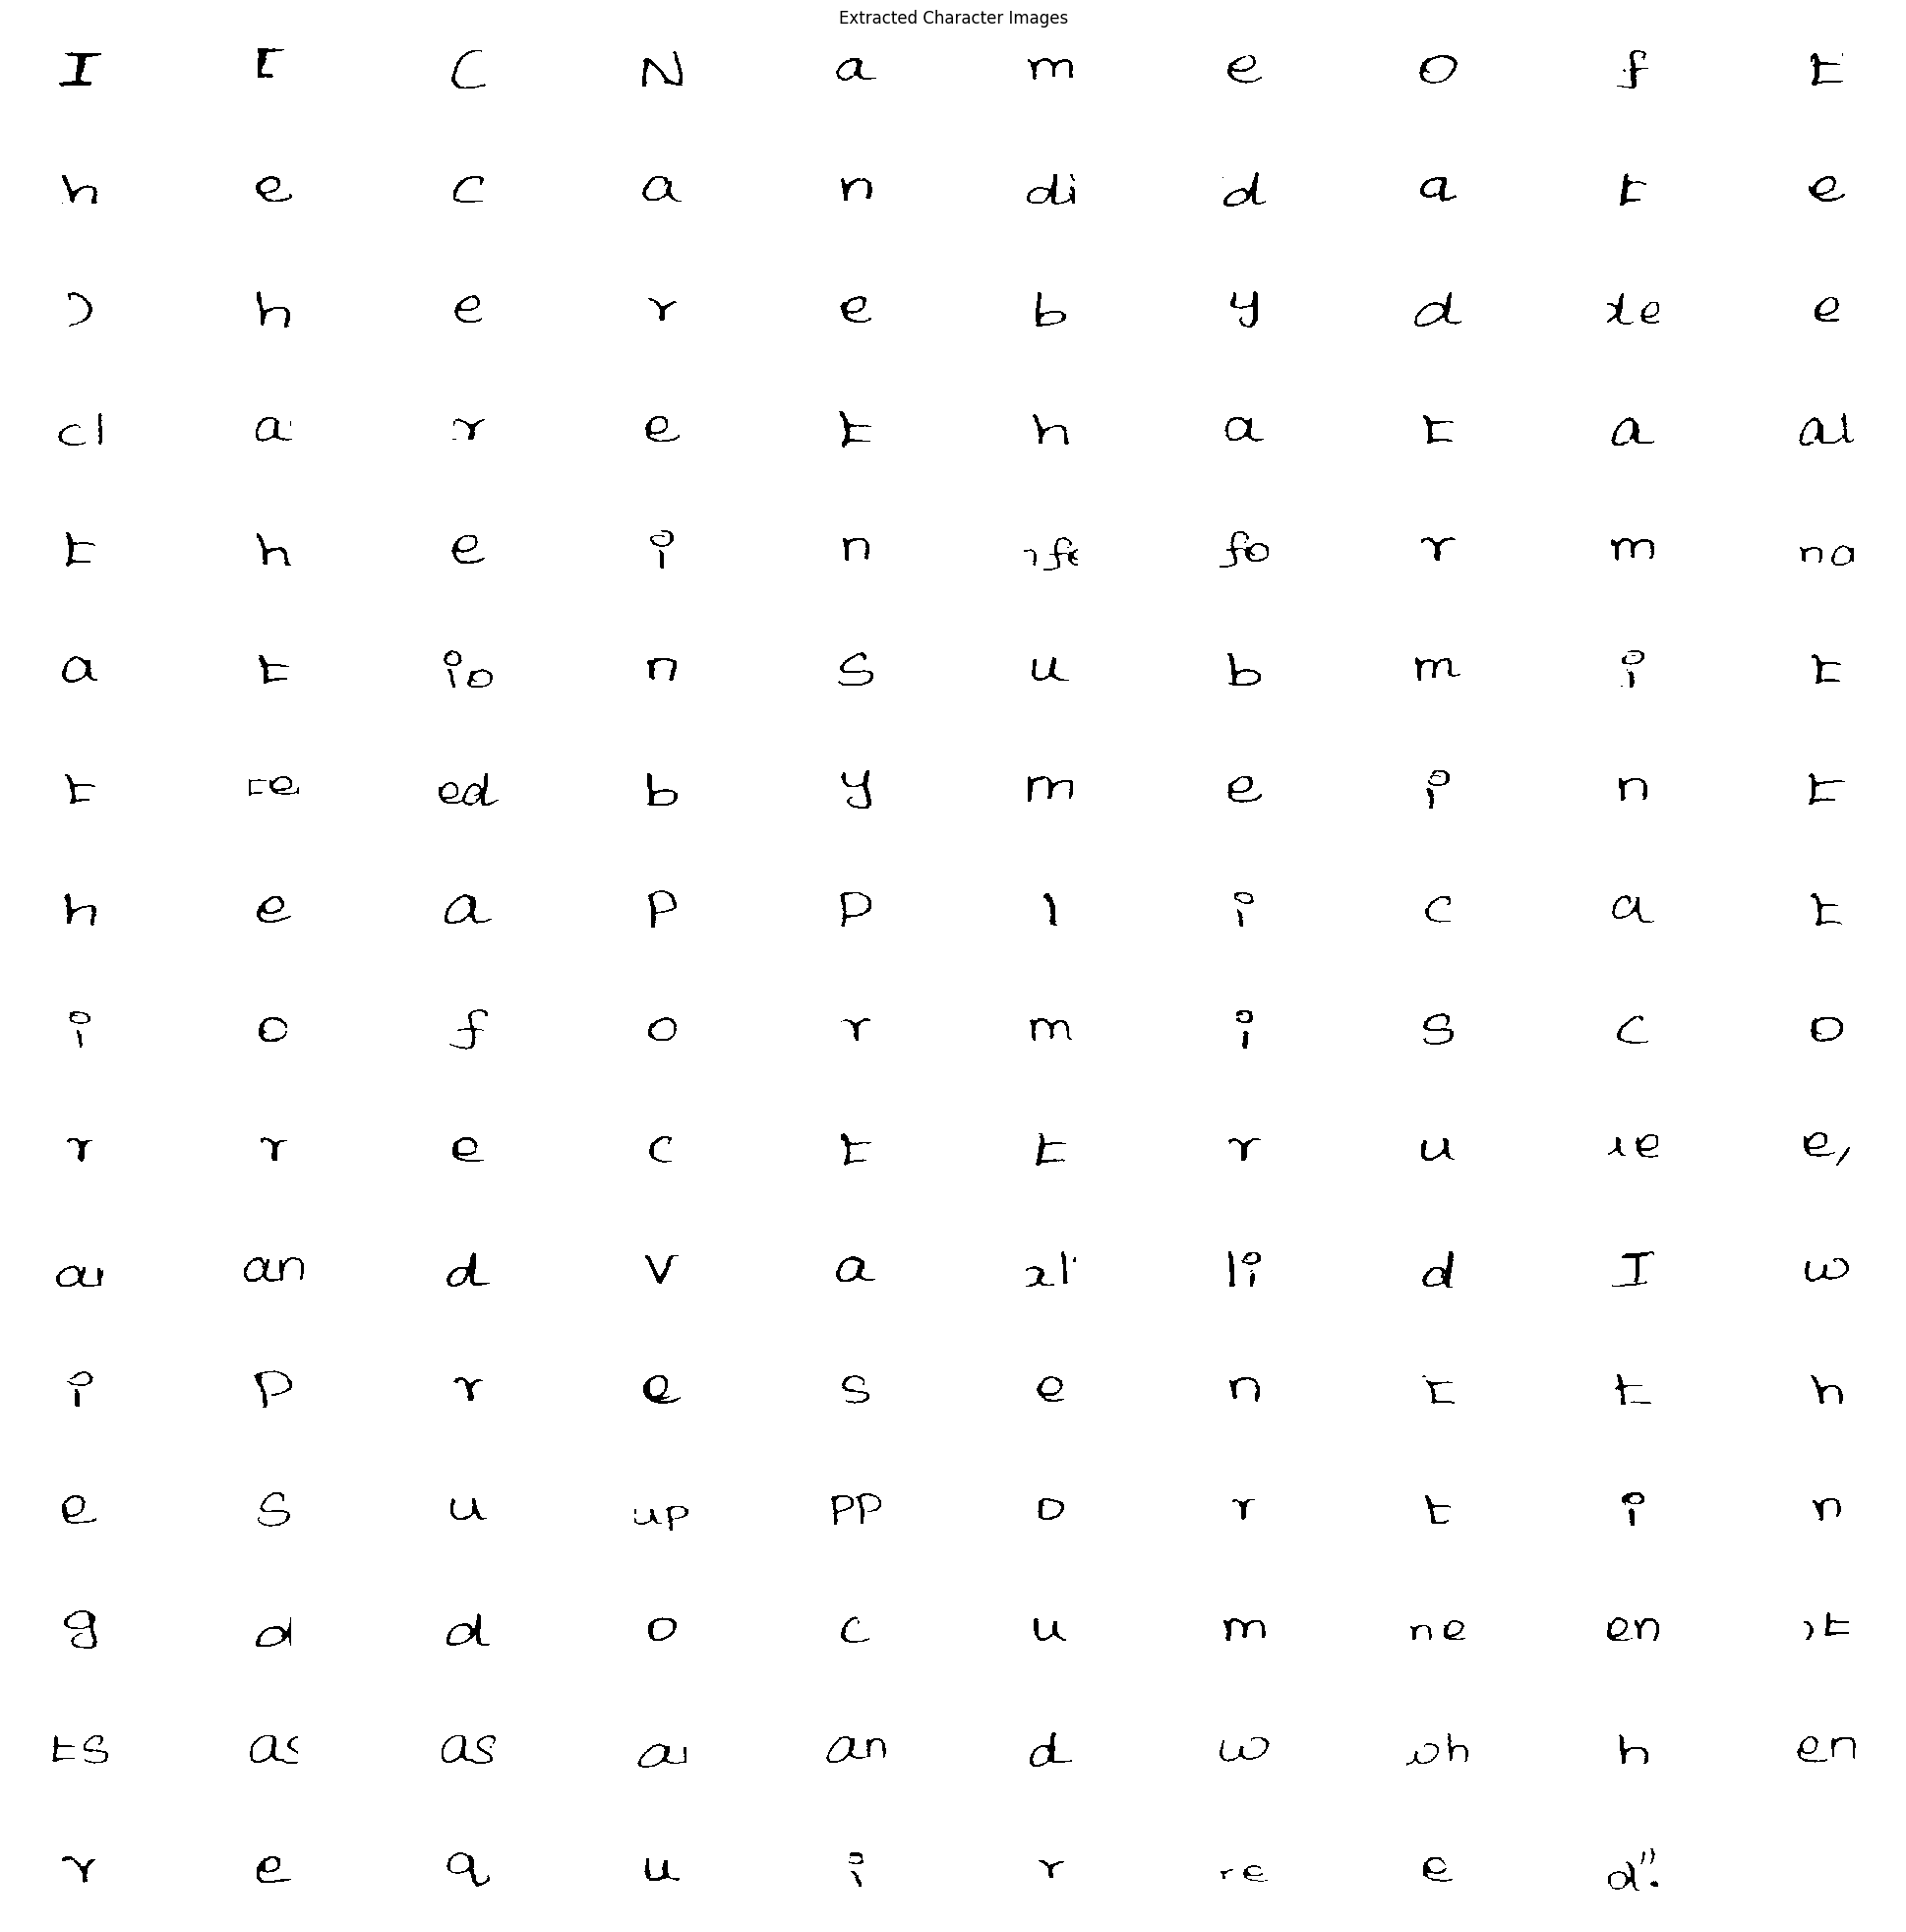

In [19]:
def preprocess_image_array(image_array, output_size=(400, 300)):
    # Convert to grayscale if the image is not already in grayscale
    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
        gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image_array

    # Binarize the image
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding box of the largest contour
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_image = binary_image[y:y+h, x:x+w]
    else:
        cropped_image = binary_image

    # Resize the image to the output size
    resized_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_AREA)

    # Apply morphological operations to sharpen edges
    kernel = np.ones((3, 3), np.uint8)
    morph_image = cv2.morphologyEx(resized_image, cv2.MORPH_CLOSE, kernel)
    morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)

    # Apply edge detection to sharpen the image
    edges = cv2.Canny(morph_image, 50, 150)
    enhanced_image = cv2.bitwise_or(morph_image, edges)

    return enhanced_image

# List to store the processed images
qualified_images = []

# Process each image and append to the qualified_images array
for image in processed_images:
    processed_image = preprocess_image_array(image)
    qualified_images.append(processed_image)

# Display all extracted character images
num_images = len(qualified_images)
rows = int(np.ceil(num_images / 10))  # Calculate number of rows needed
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(rows, 10, i+1)  # Adjust subplot grid size according to the number of characters

    # Ensure aspect ratio is maintained by setting interpolation to 'nearest'
    plt.imshow(qualified_images[i], cmap='gray', interpolation='nearest')

    plt.axis('off')
plt.suptitle('Extracted Character Images')
plt.tight_layout()  # Ensure tight layout
plt.show()


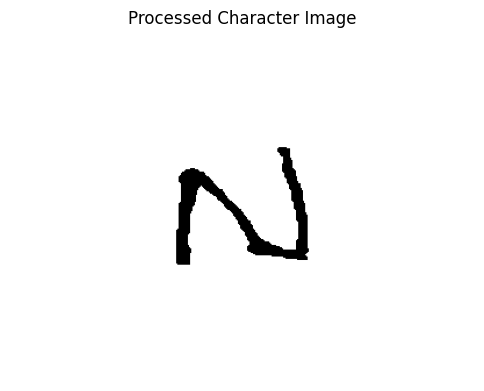

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(qualified_images[3], cmap='gray')  # Display the first processed image
plt.axis('off')
plt.title('Processed Character Image')
plt.show()

In [21]:
bold_images = []
for image in qualified_images:
    # Check if the image has 3 channels
    if len(image.shape) == 2 or image.shape[2] == 1:
        # If the image has only 1 channel, convert it to a 3-channel image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Dilate the binary image to make the black parts broader
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)

    # Invert the dilated image to restore the original colors
    inverted = cv2.bitwise_not(dilated)

    # Convert the inverted image back to RGB
    bold_image = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)

    bold_images.append(bold_image)

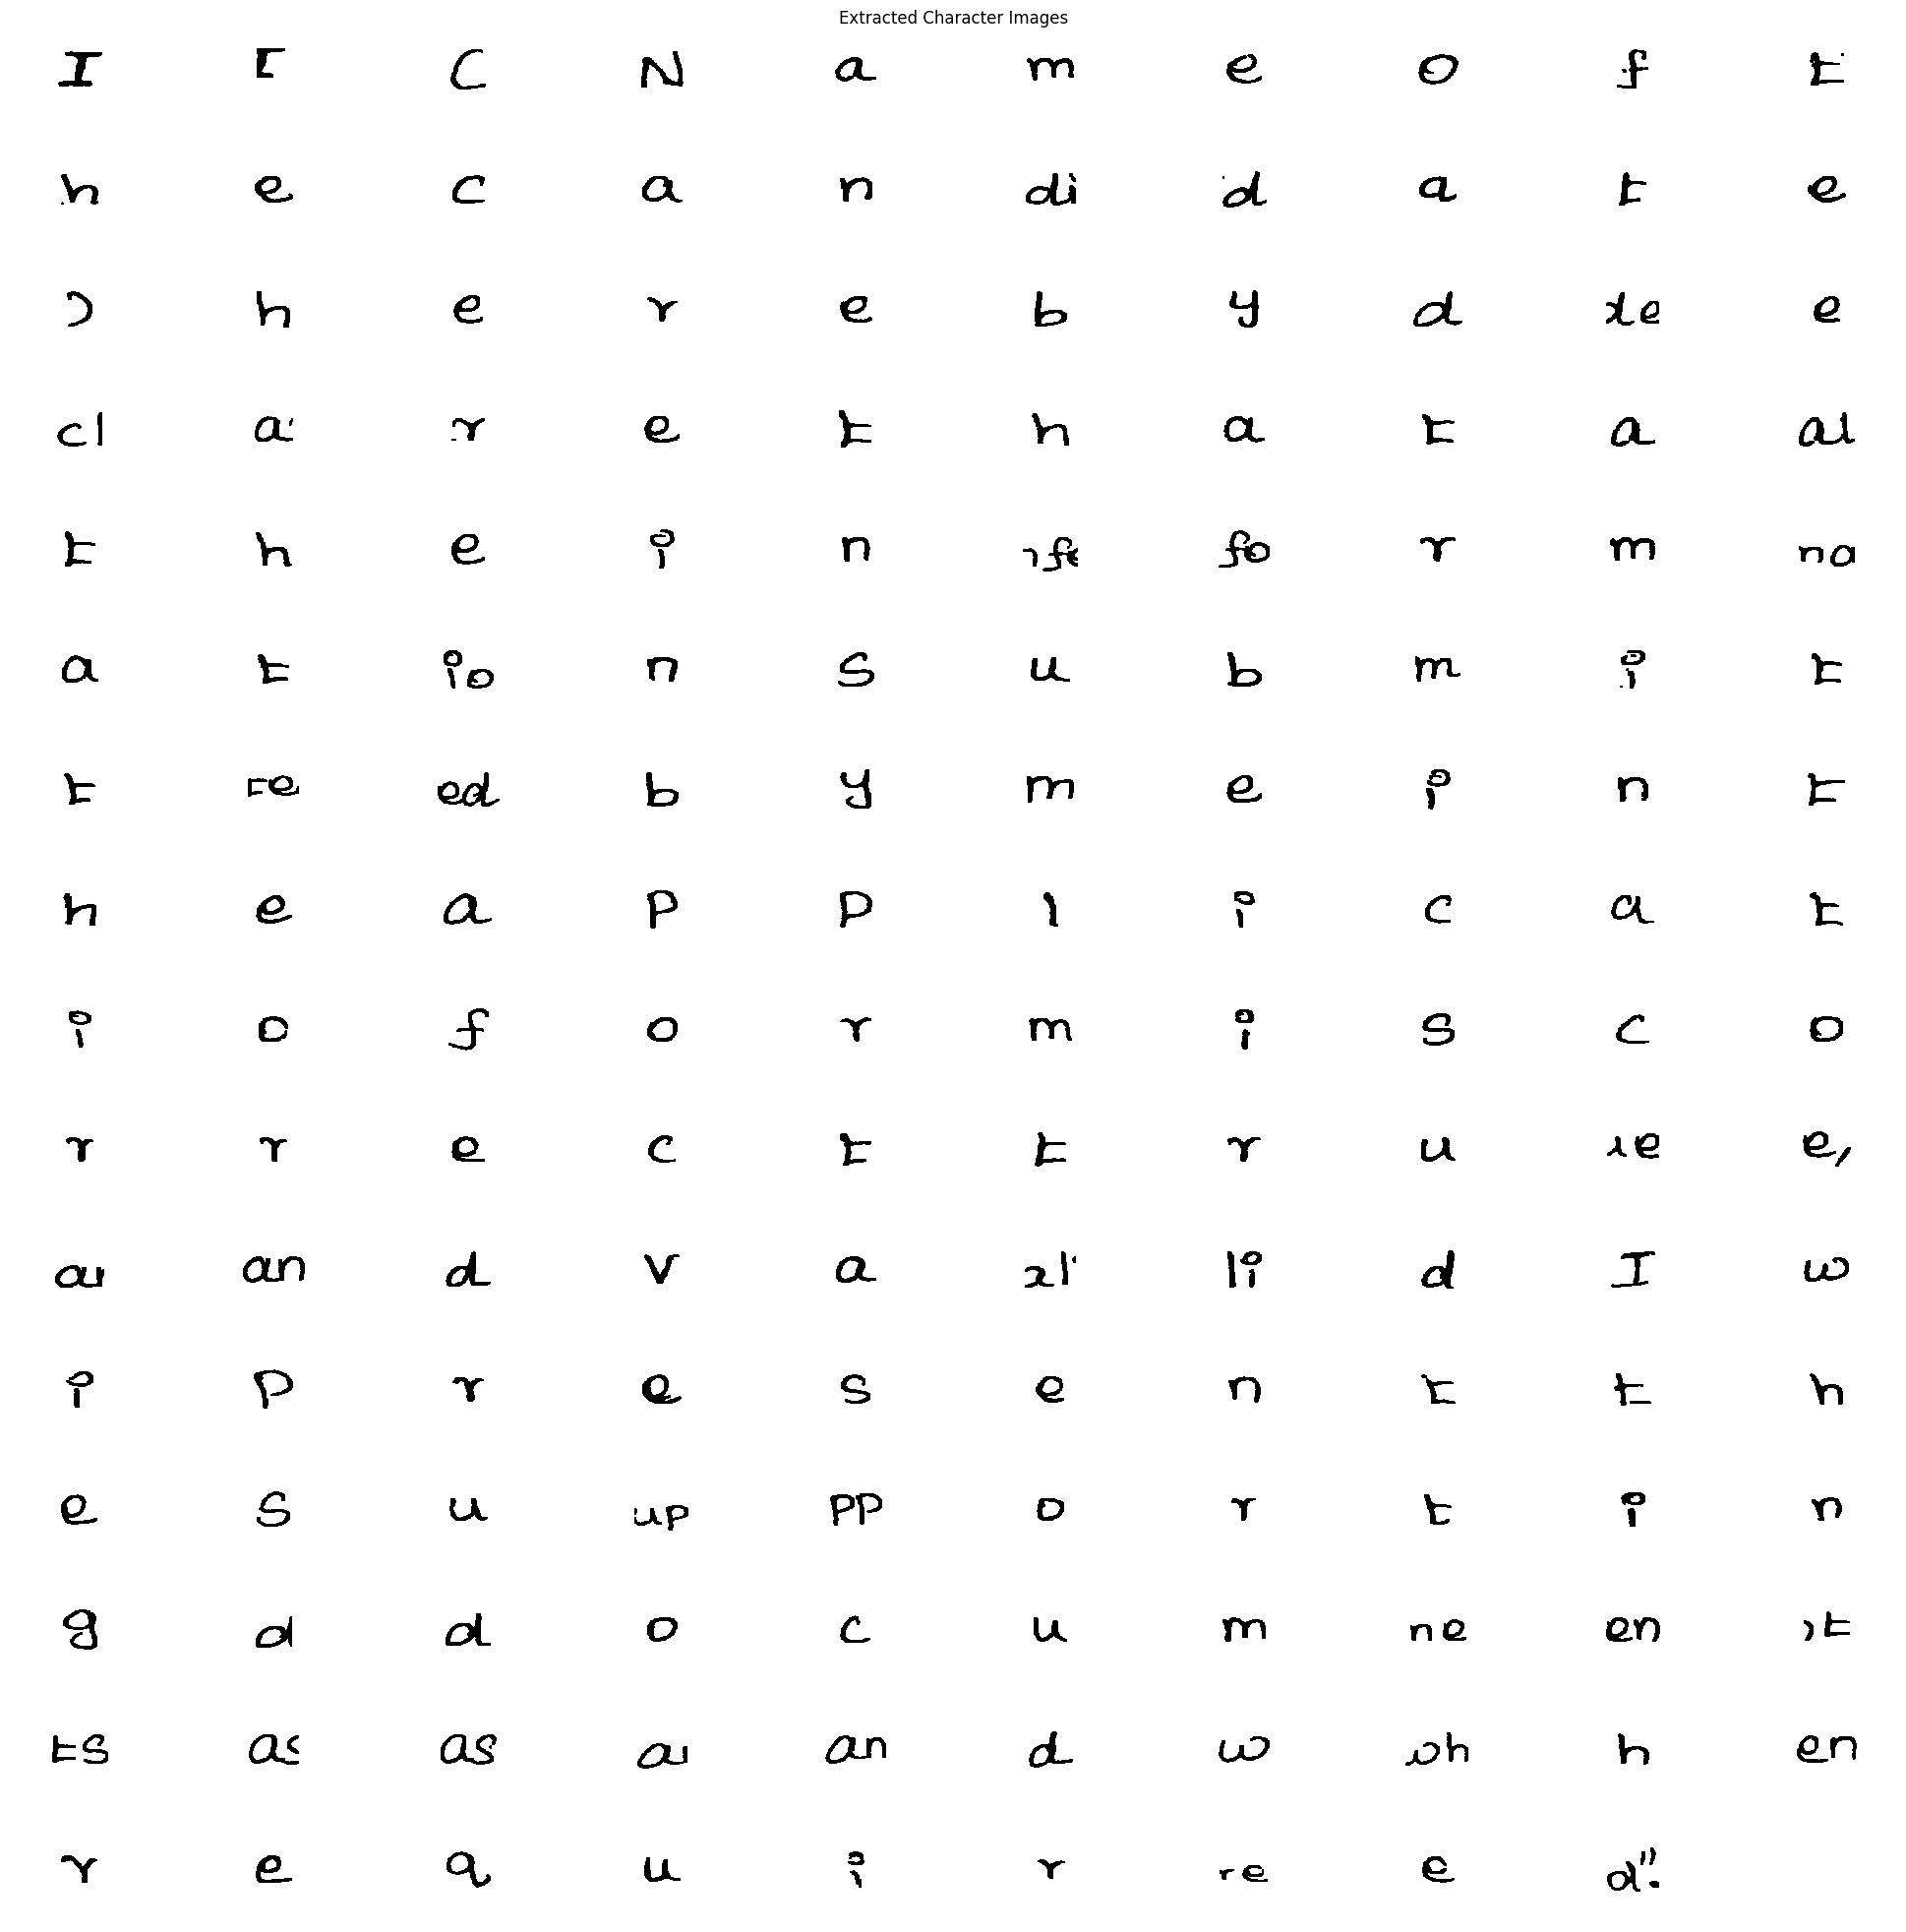

In [22]:
# Display all extracted character images
num_images = len(bold_images)
rows = int(np.ceil(num_images / 10))  # Calculate number of rows needed
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(rows, 10, i+1)  # Adjust subplot grid size according to the number of characters

    # Ensure aspect ratio is maintained by setting interpolation to 'nearest'
    plt.imshow(bold_images[i], cmap='gray', interpolation='nearest')

    plt.axis('off')
plt.suptitle('Extracted Character Images')
plt.tight_layout()  # Ensure tight layout
plt.show()

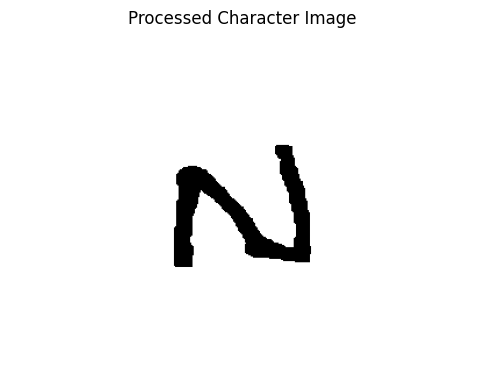

In [23]:
plt.figure(figsize=(6, 6))
plt.imshow(bold_images[3], cmap='gray')  # Display the first processed image
plt.axis('off')
plt.title('Processed Character Image')
plt.show()

In [24]:
bold_imgs = []
for image in bold_images:
    # Check if the image has 3 channels
    if len(image.shape) == 2 or image.shape[2] == 1:
        # If the image has only 1 channel, convert it to a 3-channel image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Dilate the binary image to make the black parts broader
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)

    # Invert the dilated image to restore the original colors
    inverted = cv2.bitwise_not(dilated)

    # Convert the inverted image back to RGB
    bold_image = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)

    bold_imgs.append(bold_image)

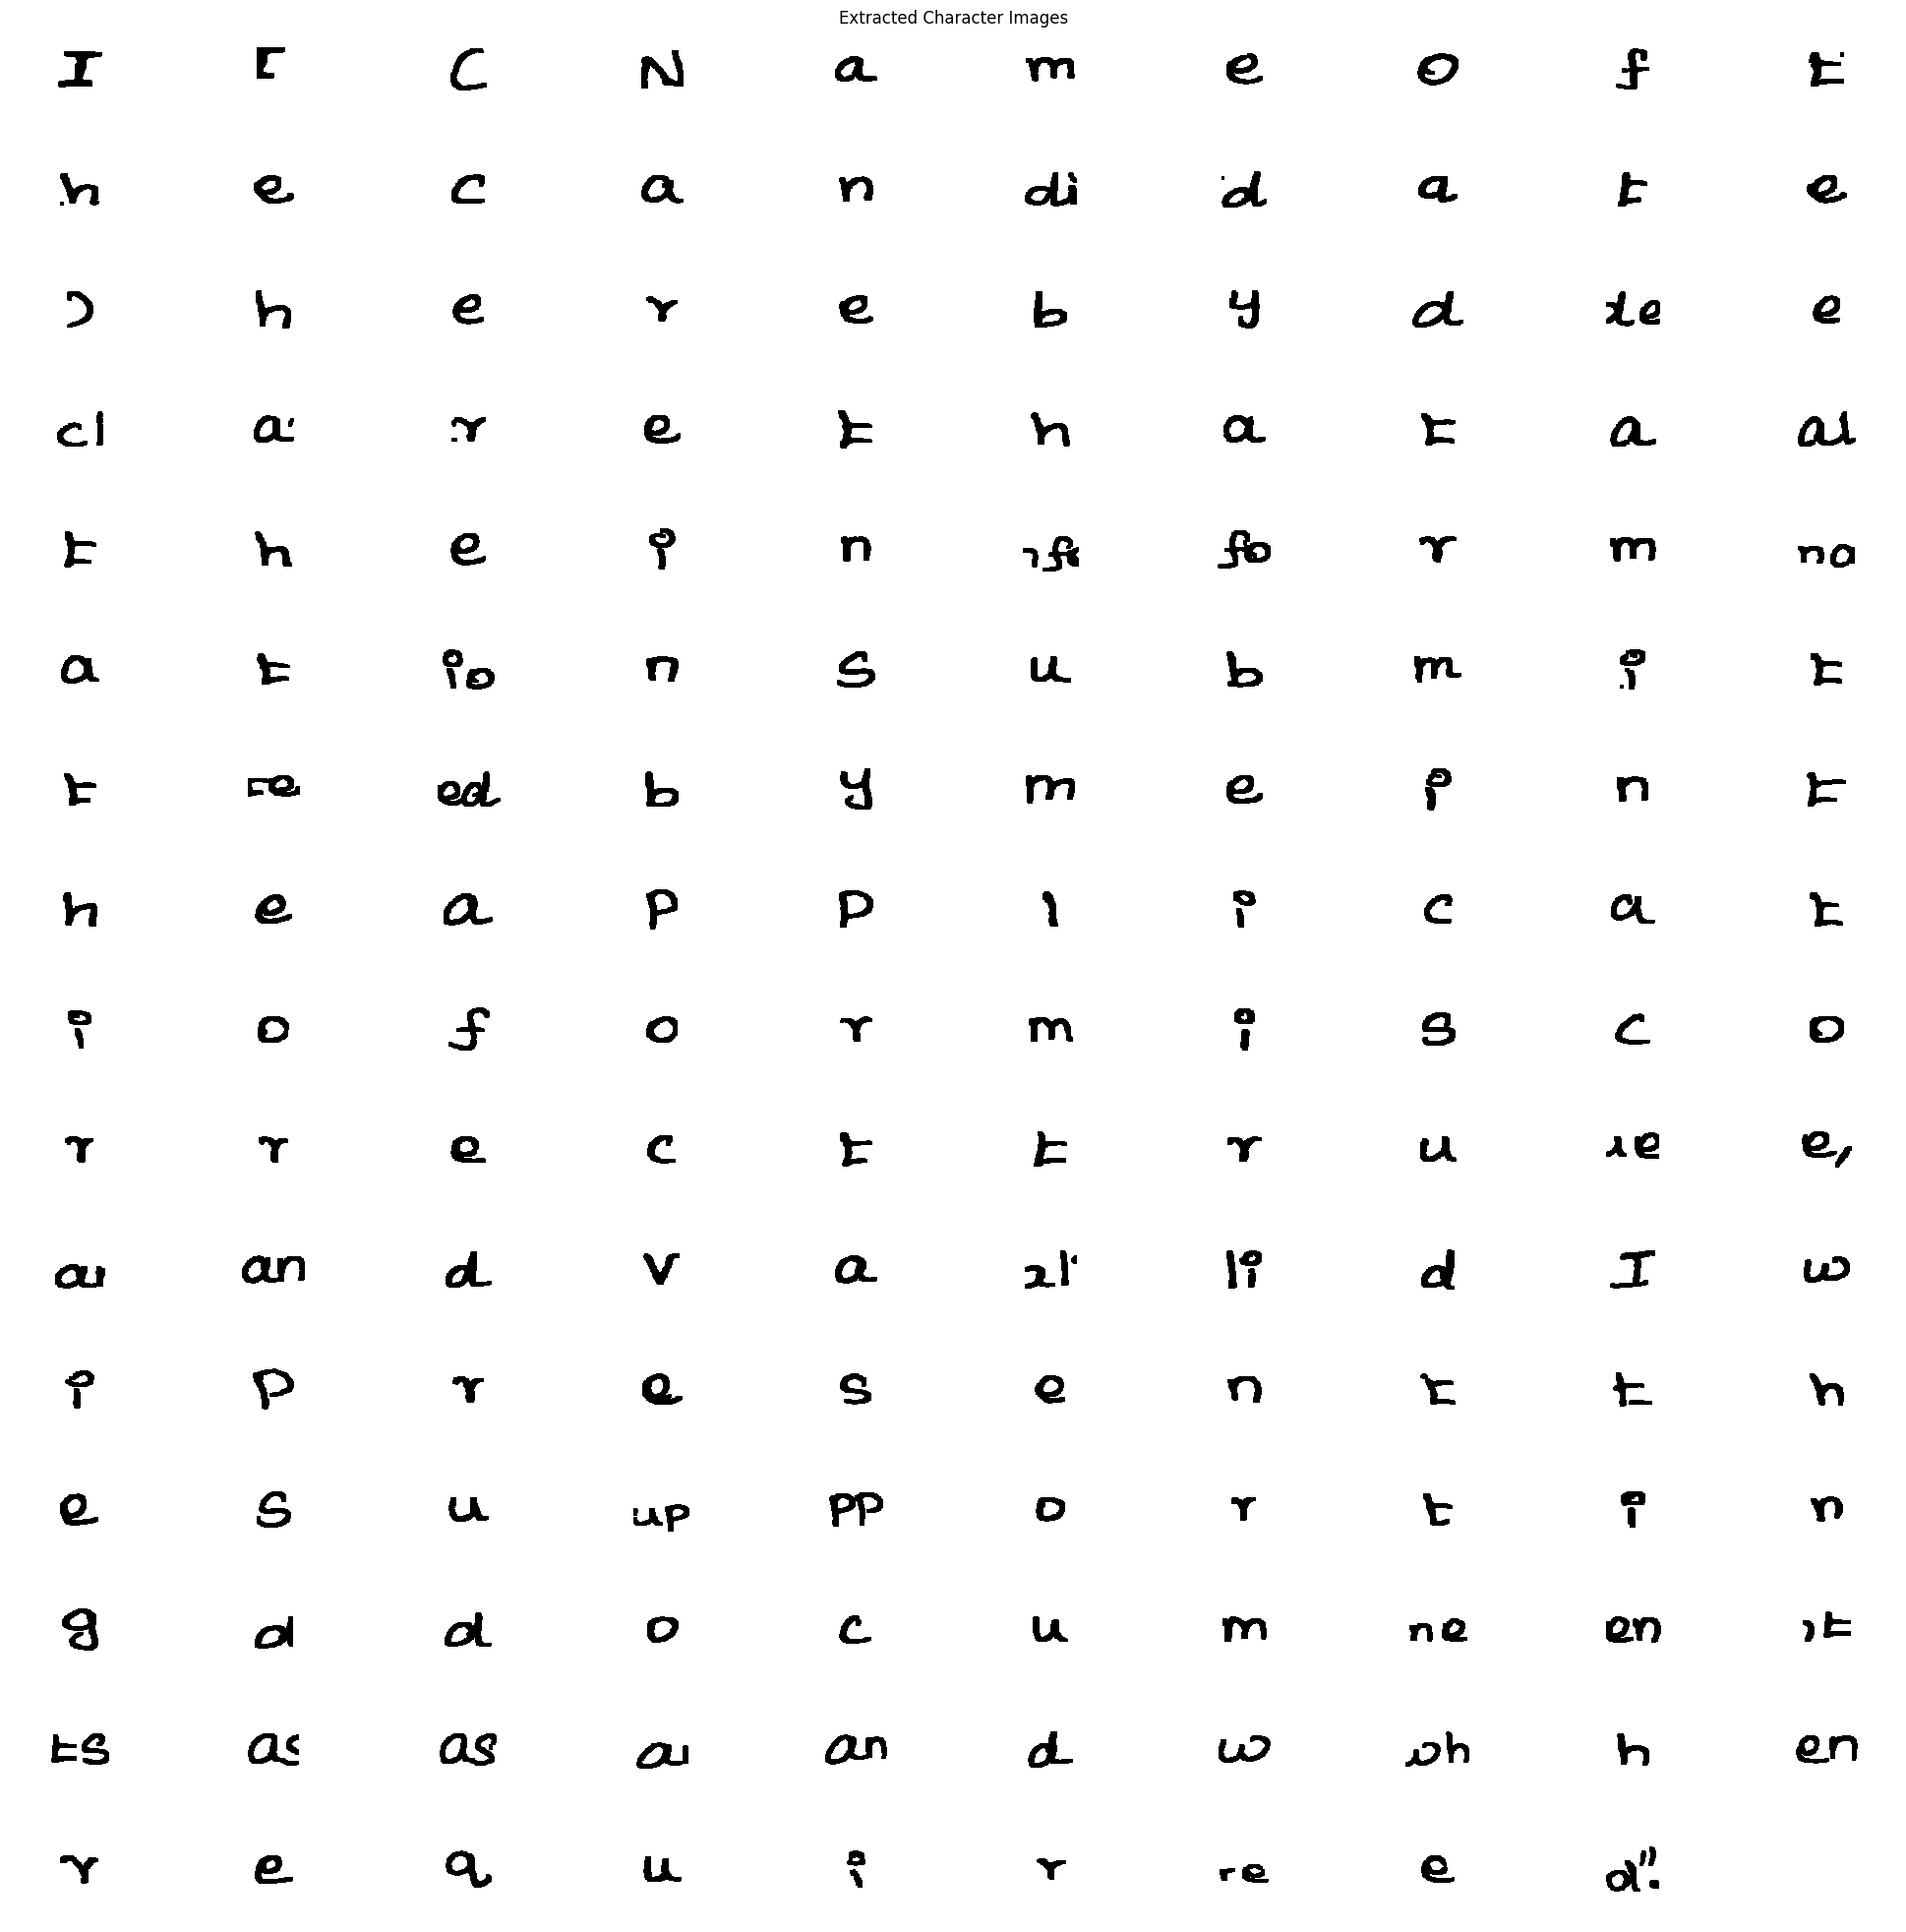

In [25]:
# Display all extracted character images
num_images = len(bold_imgs)
rows = int(np.ceil(num_images / 10))  # Calculate number of rows needed
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(rows, 10, i+1)  # Adjust subplot grid size according to the number of characters

    # Ensure aspect ratio is maintained by setting interpolation to 'nearest'
    plt.imshow(bold_imgs[i], cmap='gray', interpolation='nearest')

    plt.axis('off')
plt.suptitle('Extracted Character Images')
plt.tight_layout()  # Ensure tight layout
plt.show()

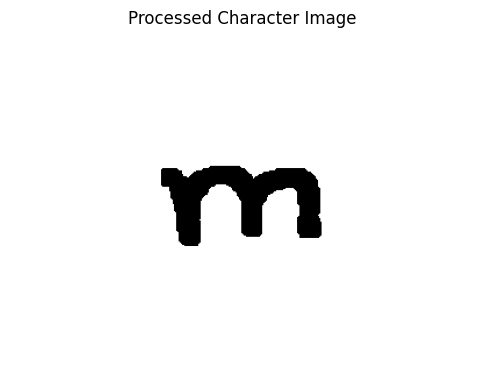

In [27]:
plt.figure(figsize=(6, 6))
plt.imshow(bold_imgs[5], cmap='gray')
plt.axis('off')
plt.title('Processed Character Image')
plt.show()